# Explain the GNN predictions

## 0. Preparations
### Imports

In [13]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.models import GraphSAGE
from torch_geometric.loader import NeighborLoader
from torch_geometric.transforms import BaseTransform
from torch_geometric.data.datapipes import functional_transform
import matplotlib.pyplot as plt
import seaborn as sns

# Snippets from my Master Thesis repository so that the non-relevant parts of the code are as short as possible
from src.data_loading import get_spatial_data
from src.graph_construction import build_delaunay_graph

### Check for GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Define a Random Number Generator

In [3]:
rng = torch.Generator()
rng.manual_seed(42)

## 1. Graph Construction and Model Training

### Define Hyperparameters

The hyperparameters are all chosen according to the results of the evaluation that is the main part of the thesis.

In [4]:
# For graph construction (Radius Delanay)
graph_construction_radius = 0.00018225
self_loops = False  # Self-Loops will not be used since we want to minimize the effect of the gene expression profile of the node itself
edge_weights = False
train_frac = 0.8  # The fraction of nodes that should be used for training. It will be assigned randomly and the rest will be used for testing.

# For the GNN model (GraphSAGE)
num_layers = 3
hidden_channels = 128
activation = "relu"
dropout_rate = 0.2

# For the training algorithm (Adam)
lr = 0.01
weight_decay = 1e-5
n_epochs = 20

### Load Data

In [5]:
cells, genes = get_spatial_data("intestine")

cell_coordinates = cells[["x", "y"]].values
features = genes.values
true_labels = cells["cluster_id"].values
ordered_names = (
    cells[["cluster_id", "cell_type"]].drop_duplicates().set_index("cluster_id").sort_index()["cell_type"].values
)

print("Cell coordinates: ", cell_coordinates.shape)
print("Features: ", features.shape)
print("True labels: ", true_labels.shape)  # Must be 1D array!

Cell coordinates:  (7416, 2)
Features:  (7416, 241)
True labels:  (7416,)


In [15]:
cells

,x,y,cluster_id,cell_type
cell_id,,,,
cell1,0.281503,0.001062,17,Telocyte
cell2,0.281681,0.008326,12,Smooth Muscle
cell3,0.285644,0.005628,14,Stromal
cell4,0.297410,0.003399,12,Smooth Muscle
cell5,0.314682,0.002222,12,Smooth Muscle
...,...,...,...,...
cell8165,0.681613,0.423732,11,Pericyte
cell8166,0.739579,0.435653,14,Stromal
cell8167,0.624379,0.522567,8,Macrophage + DC


<Axes: xlabel='x', ylabel='y'>

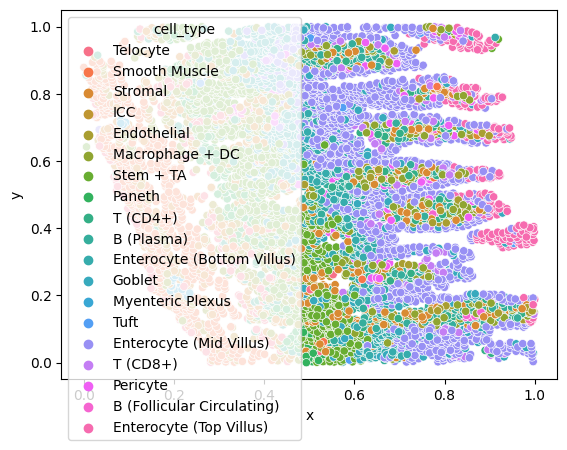

In [16]:
sns.scatterplot(cells, x="x", y="y", hue="cell_type")

### Construct Radius-Delaunay Graph

This is the overall best performing graph construction method so we will use it for the following.

In [6]:
graph = build_delaunay_graph(
    positions=cell_coordinates,
    include_self_loops=self_loops,
    add_distance=edge_weights,
    features=features,
    labels=true_labels, # TODO: Change to `features` since this is our new target
    library="pyg", # The only available option since the code snippet is not the complete version of the normal code
)

num_labels = len(np.unique(true_labels))
num_nodes = graph.num_nodes
num_edges = graph.num_edges

print("Number of labels:", num_labels)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", num_edges / num_nodes)

Number of labels: 19
Number of nodes: 7416
Number of edges: 44452
Average degree: 5.994066882416397


### Train/Test Split

Since we are not changing any hyperparameter and are not really interested in the performance of the model itself, we will omit the validation set and just use the test set for evaluation.

In [7]:
def assign_random_splits(graph: Data) -> Data:
    """Takes the generated PyG graph as input and assigns a mask for the train and test split that is used for training and evaluation. The PyG graph will be returned with the assigned split."""
    graph = graph.clone()
    random_indices = torch.randperm(num_nodes, generator=rng)

    train_indices = random_indices[: int(num_nodes * train_frac)]
    test_indices = random_indices[int(num_nodes * train_frac) :]

    # Not all datatypes are allowed for the index: Only bool, byte or long
    graph.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    graph.train_mask[train_indices] = 1
    graph.test_mask[test_indices] = 1
    return graph

# TODO

In [8]:
class MaskNodeFeature:
    def __init__(self, masking_type: str = "ones") -> None:
        self.masking_type = masking_type

    def __call__(self, data: Data) -> Data:
        if self.masking_type == "ones":
            data.x[:data.batch_size] = torch.ones_like(data.x[:data.batch_size])
        elif self.masking_type is not None:
            raise NotImplementedError()
        return data

In [9]:
# The configurations chosen in the following are chosen as the overall best after the main grid search
def train_model(graph: Data, batch_size = 1) -> tuple[GraphSAGE, Data]:
    """Initializes and trains the model"""
    model = GraphSAGE(
        in_channels=features.shape[1],
        out_channels=num_labels, # TODO: Change to input size as we want to essentially predict the input
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout_rate,
        act=activation,
        jk="last",  # This adds a final linear layer after the GNN layers
        # arguments that are passed to the Convolutional layer
        aggr="max",
        normalize=True,
        root_weight=True,
        project=True,
        bias=True,
    )

    # Move model to the correct device memory. Needed for training on the GPU.
    model = model.to(device)
    transform = MaskNodeFeature()

    graph = assign_random_splits(graph)
    train_loader = NeighborLoader(
        graph,
        num_neighbors=[-1] * num_layers, # Sample all neighbors per each GNN layer
        batch_size=batch_size,
        input_nodes=graph.train_mask,
        transform=transform
        )
    test_loader = NeighborLoader(
        graph,
        num_neighbors=[-1] * num_layers, # Sample all neighbors per each GNN layer
        batch_size=batch_size,
        input_nodes=graph.test_mask,
        transform=transform
        )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    # Training loop
    for _ in range(1, n_epochs):
        
        # TODO: Change from full batch to single batch
        # Can be done with the NeighborLoader in PyG: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
        # An Example: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/ogbn_products_sage.py
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = F.cross_entropy(out[:batch.batch_size], batch.y[:batch.batch_size]) # TODO: Change to something that is fitting for a regression task. MSE probably...
            loss.backward()
            optimizer.step()

    # Test the model
    model.eval()
    total_correct = 0
    for batch in test_loader:
        pred = model(batch.x, batch.edge_index).argmax(dim=-1)
        total_correct += int((pred[:batch.batch_size] == batch.y[:batch.batch_size]).sum())
    print(f"Finished training with an accuracy of {total_correct / int(graph.test_mask.sum()):.4f} for the test set")

    return model, graph

In [10]:
graph = graph.to(device)
model, curr_graph = train_model(graph, 1)

Finished training with an accuracy of 0.5418 for the test set
